# 1. Setup

### 1.1 Install Dependencies

In [1]:
# pip install tensorflow

In [2]:
# pip install tensorflow-gpu

In [3]:
# pip install opencv-python

In [4]:
# pip install matplotlib

### 1.2 Import Libraries

In [5]:
import os
import cv2
import sys
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

2022-12-26 10:50:01.071142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 10:50:01.221483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sangramdh/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-26 10:50:01.221504: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-26 10:50:01.790345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dl

### 1.3 Check GPU

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-12-26 10:50:03.076660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sangramdh/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-26 10:50:03.076677: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-26 10:50:03.076709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GaribaITServices): /proc/driver/nvidia/version does not exist


In [7]:
tf.test.is_built_with_cuda()

True

In [8]:
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

Number of GPUs available:  0


In [9]:
print(tf.version.VERSION)

2.11.0


In [10]:
sys.version

'3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]'

### 1.4 Create Folders

In [11]:
# set all paths
Pos_path = os.path.join('data', 'positive')
Neg_path = os.path.join('data', 'negative')
Anc_path = os.path.join('data', 'anchor')

In [12]:
# # make the directories, ones we create this and then comment it out
# os.makedirs(Pos_path)
# os.makedirs(Neg_path)
# os.makedirs(Anc_path)

# 2. Collect Positives and Anchors

### 2.1 Unzip Labelled Faces from given dataset

In [13]:
# # move Images to the following directories data/negatives
# path = '/home/sangramdh/data/data/'
# for directory in os.listdir(path):
#     for file in os.listdir(os.path.join(path, directory)):
#         ex_path = os.path.join(path, directory, file)
#         new_path = os.path.join(Neg_path, file)
#         os.replace(ex_path, new_path)

### 2.2 Collect Positive and Anchor Classes

In [14]:
# # universal unique identification
# import uuid

In [15]:
# os.path.join(Anc_path, '{}.jpg'.format(uuid.uuid1()))

In [16]:
# open webcam for collect images
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # cut frame in required size
    frame = frame[120:120+250,200:200+250, :]
    
    # for collecting anchor images press "a"
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create the pathq
        imgname = os.path.join(Anc_path, '{}.jpg'.format(uuid.uuid1()))
        # write anchor images
        cv2.imwrite(imgname, frame)
    
    # for collecting anchor images press "p"
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(Pos_path, '{}.jpg'.format(uuid.uuid1()))
        # write positive images
        cv2.imwrite(imgname, frame)
    
    # show image
    cv2.imshow('Image Collection', frame)
    
    # come out of camera
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [17]:
# frame.shape

In [18]:
# plt.imshow(frame)

### 2.3 Data Augmentation

In [19]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [20]:
import glob

path = '/home/sangramdh/jupyter/Siamese_Architecture/data/anchor/*'

res = glob.glob(path)
len(res)

In [21]:
img_path = os.path.join(Anc_path, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(Anc_path, '{}.jpg'.format(uuid.uuid1), image.numpy())

In [22]:
for file_name in os.listdir(os.path.join(Pos_path)):
    img_path = os.path.join(Pos_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(Pos_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

### 3.1 Get Image Directories

In [23]:
anchor = tf.data.Dataset.list_files(Anc_path+'/*.jpg').take(500)
positive = tf.data.Dataset.list_files(Pos_path+'/*.jpg').take(500)
negative = tf.data.Dataset.list_files(Neg_path+'/*.jpg').take(500)

2022-12-26 10:50:03.154884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
dir_test = positive.as_numpy_iterator()

In [25]:
print(dir_test.next())

b'data/positive/b67b7e89-80f4-11ed-aa35-cd4e47d680d3.jpg'


### 3.2 Preprocessing - Scale and Resize

In [26]:
def preprocess(file_path):
    # read image from file path
    raw_img = tf.io.read_file(file_path)
    # image load
    img = tf.io.decode_jpeg(raw_img)
    # get required size
    img = tf.image.resize(img, (105, 105))
    # normalize image b/w 0 and 1
    img = img / 255.0
    return img

In [27]:
img = preprocess('/home/sangramdh/jupyter/Siamese_Architecture/data/anchor/4bc6ca97-80f4-11ed-aa35-cd4e47d680d3.jpg')

In [28]:
img.numpy().max()

1.0

### 3.3 Create Labelled Dataset

In [29]:
# positive => 1,1,1,1,1
# negative => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [30]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [31]:
samples = data.as_numpy_iterator()
samples

In [32]:
example = samples.next()
example

(b'data/anchor/3b16d572-80f4-11ed-aa35-cd4e47d680d3 (copy).jpg',
 b'data/positive/3d7fb310-80f6-11ed-aa35-cd4e47d680d3.jpg',
 1.0)

### 3.4 Build Train and Test Partition

In [33]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [34]:
resu = preprocess_twin(*example)

In [35]:
resu[1] # resu[0], resu[2]

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.6389245 , 0.57412744, 0.47216666],
        [0.65638256, 0.59419763, 0.49139655],
        [0.64128095, 0.586379  , 0.47265354],
        ...,
        [0.42296916, 0.45826328, 0.4530123 ],
        [0.44364417, 0.4668868 , 0.45650932],
        [0.4570495 , 0.46489263, 0.45312792]],

       [[0.6177671 , 0.5749099 , 0.46594638],
        [0.6263905 , 0.5827131 , 0.4739896 ],
        [0.64692545, 0.5925837 , 0.48698145],
        ...,
        [0.37152866, 0.4034614 , 0.41102445],
        [0.42683074, 0.4520008 , 0.45146057],
        [0.44229025, 0.45797652, 0.45405495]],

       [[0.5851096 , 0.55373704, 0.48987147],
        [0.59357744, 0.561618  , 0.49335736],
        [0.6212707 , 0.5824841 , 0.5034747 ],
        ...,
        [0.38039216, 0.41605976, 0.42352942],
        [0.4159998 , 0.4463786 , 0.4447913 ],
        [0.4509804 , 0.46666667, 0.4627451 ]],

       ...,

       [[0.5844293 , 0.6269019 , 0.6132097 ],
        [0.60

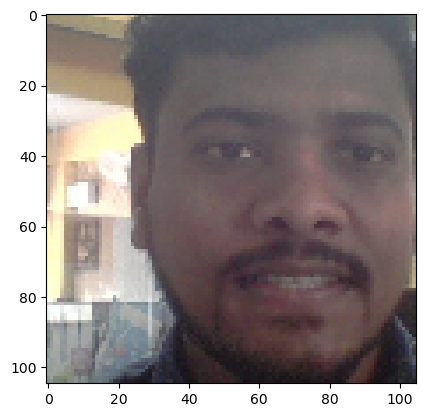

In [36]:
plt.imshow(resu[1])

In [37]:
# DataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [38]:
len(data)

1000

In [94]:
da_test = data.as_numpy_iterator()

In [99]:
test_im = da_test.next()

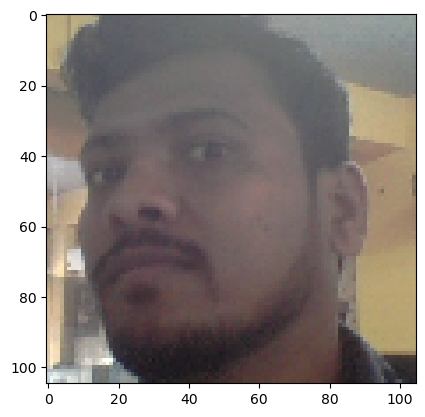

In [100]:
plt.imshow(test_im[1])

In [42]:
test_im[2] # checked label is correct or not

0.0

In [43]:
round(len(data)*.7)

700

In [44]:
# training data
train_data = data.skip(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
round(len(data)*.3)

300

In [46]:
# testing data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [47]:
len(test_data)

19

# 4. Model Engineering

### 4.1 Build Embedding Layer

In [48]:
inp = Input(shape=(105,105,3), name='input_image')
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [49]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [50]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [51]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_1')>

In [52]:
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [53]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
c3

<KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'conv2d_2')>

In [54]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [55]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [56]:
f1 = Flatten()(c4)
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [57]:
d1 = Dense(4096, activation='sigmoid')(f1)
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [58]:
modl = Model(inputs=[inp], outputs=[d1], name='embedding')
modl

In [59]:
modl.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [60]:
# make a embedding fx
def make_emmbedding():
    inp = Input(shape=(105, 105, 3), name="input_image")
    
    # block-1
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)
    
    # Block-2
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Block-3
    c3 = Conv2D(128, (4, 4), activation ='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final-Block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [61]:
embedding = make_emmbedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

### 4.2 Build Distance Layer

In [62]:
# L1 distance class , note- we have imported "Layer" from keras
class L1_dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    # similarity calculation        
    def cal(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [63]:
l1 = L1_dist()

In [64]:
# we will define it later
# l1(anchor_embedding, validation_embedding)

### 4.3 Make Siamese Model

In [65]:
input_image = Input(name='input_img', shape=(105, 105, 3))
validation_image = Input(name='validation_img', shape=(105, 105, 3))

In [66]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [67]:
siamese_layer = L1_dist()

In [68]:
distances = siamese_layer(inp_embedding, val_embedding)

In [69]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [70]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [71]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [72]:
# make a siamese model fx
def make_siamese_model():
    # anchor input
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # validation input
    vaidation_image = Input(name='validation_img', shape=(105, 105, 3))
    
    # combine
    siamese_layer = L1_dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [73]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

### 5.1 Setup Loss and Optimizer

In [74]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [75]:
optm = tf.keras.optimizers.Adam(1e-4) # set to 0.0001

### 5.2 Establish Checkpoints

In [76]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optm, siamese_model=siamese_model)

### 5.3 Build Train Step Function

In [77]:
test_batch = train_data.as_numpy_iterator()

In [78]:
batch_1 = test_batch.next()

In [79]:
X = batch_1[:2]

In [80]:
y = batch_1[2]

In [81]:
y  #len(y)

array([0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.],
      dtype=float32)

In [82]:
@tf.function # compiles a function into a callable Tensorflow graph
def train_step(batch):
    
    # Record all of our operations automatic defferentiation
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        y_pred = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, y_pred)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    optm.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### 5.4 Build Training Loop

In [83]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [84]:
def train(data, epochs):
    # Loop through epochs
    for epoch in range(1, epochs+1):
        print('\n Epoch {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for indx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            y_pre = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pre)
            p.update_state(batch[2], y_pre) 
            progbar.update(indx+1)
        print("Loss=> ",loss.numpy(), "Recall=> ",r.result().numpy(), "Precision=> ",p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5 Train the Model

In [85]:
epochs = 10

In [86]:
# train(train_data, epochs)

# 6. Evaluate Model

### 6.1 Make Predictions

In [139]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [140]:
y_predd = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 495ms/step


In [141]:
[ 1 if prediction > 0.6 else 0 for prediction in y_predd]

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]

In [142]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

### 6.2 Calculate Metrics

In [143]:
# recall matrix
mat = Recall()

mat.update_state(y_true, y_predd)

mat.result().numpy()

1.0

In [144]:
# precision matrix
mtx = Precision()
mtx.update_state(y_true, y_predd)

mtx.result().numpy()

0.125

In [145]:
# both matrices
r = Recall()
p = Precision()

for test_input,test_val, y_true in test_data.as_numpy_iterator():
    y_pred = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, y_pred)
    p.update_state(y_true, y_pred)
    
print("Recall score is: ", r.result().numpy(), "Precision score is: ", p.result().numpy())

1/1 [==============================] - 0s 422ms/step
Recall score is:  1.0 Precision score is:  0.5


### 6.3 Create Result visualization

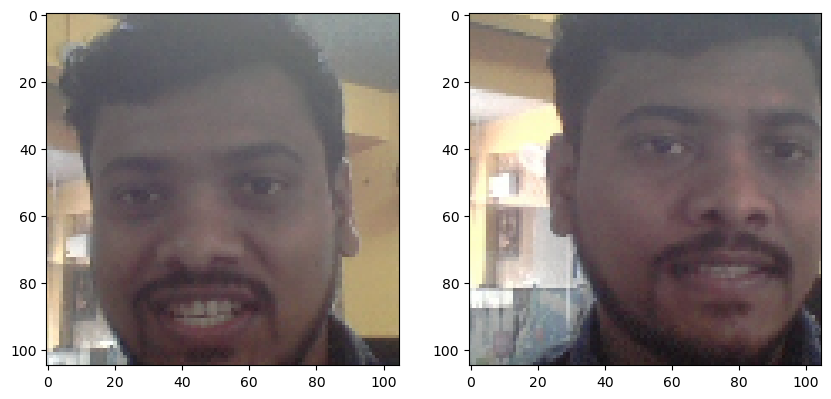

In [146]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])
plt.show()

# 7. Save Model

In [148]:
# Save weights
siamese_model.save('siamese_network_v2.h5')

In [149]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamese_network_v2.h5', 
                                   custom_objects={'L1_dist':L1_dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [4]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model('/home/sangramdh/jupyter/Siamese_Architecture/siamese_network_v2.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

OSError: SavedModel file does not exist at: /home/sangramdh/jupyter/Siamese_Architecture/siamese_network_v2.h5/{saved_model.pbtxt|saved_model.pb}

In [150]:
# predictions with loaded model
siamese_model.predict([test_input, test_val])


1/1 [==============================] - 0s 463ms/step


array([[0.6000734 ],
       [0.6000426 ],
       [0.6001176 ],
       [0.59962934],
       [0.5998098 ],
       [0.6002694 ],
       [0.6004321 ],
       [0.6000715 ],
       [0.5992563 ],
       [0.59993   ],
       [0.60007995],
       [0.6002757 ]], dtype=float32)

# 8. Real Time Test

In [151]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/home/sangramdh/jupyter/Siamese_Architecture/app/application_data/', '/home/sangramdh/jupyter/Siamese_Architecture/app/application_data/verification_images/')):
        input_img = preprocess(os.path.join('/home/sangramdh/jupyter/Siamese_Architecture/app/application_data/', '/home/sangramdh/jupyter/Siamese_Architecture/app/application_data/input_image/', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('/home/sangramdh/jupyter/Siamese_Architecture/app/application_data/', '/home/sangramdh/jupyter/Siamese_Architecture/app/application_data/verification_images/', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.1 From Camera

In [1]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results

In [8]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 3.1 MB/s eta 0:00:00m eta 0:00:010:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 14.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 18.9 MB/s eta 0:00:0031m22.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 7.9 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch

In [10]:
torch.__version__

'1.13.1+cu117'

In [11]:
torch.cuda.is_available()

False

In [13]:
torch.cuda.get_device_name(0)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx